In [4]:
#Importing openCV
import cv2
import matplotlib.pyplot as plt
import numpy as np

### Input Image

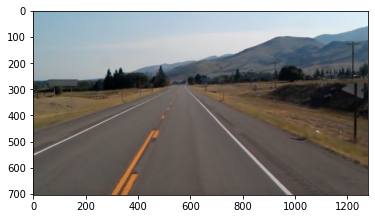

In [3]:
image = cv2.imread('test_image.jpg')
plt.imshow(image[...,::-1])

### Converting the image to grayscale

In [6]:
lanelines_image = np.copy(image)

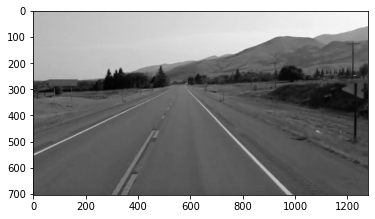

In [8]:
gray_conversion= cv2.cvtColor(lanelines_image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray_conversion,cmap='gray')

### Applying Gaussian Blur to reduce noise

In [9]:
blur_conversion = cv2.GaussianBlur(gray_conversion, (5,5),0)

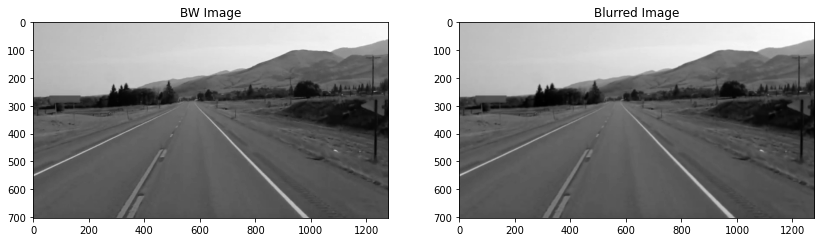

In [19]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1);plt.title('BW Image');plt.imshow(gray_conversion,cmap='gray')
plt.subplot(1,2,2);plt.title('Blurred Image');plt.imshow(blur_conversion,cmap='gray')

### Canny edge detection

In [11]:
canny_conversion = cv2.Canny(blur_conversion, 50,155)

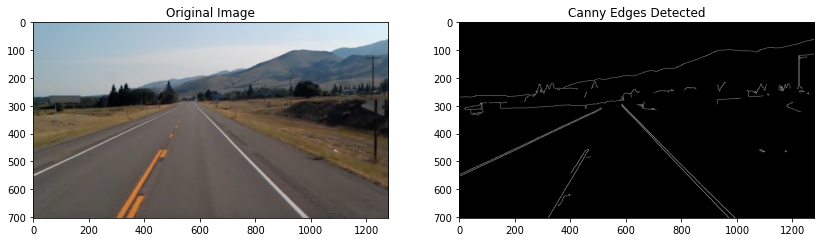

In [16]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1);plt.title('Original Image');plt.imshow(image[...,::-1])
plt.subplot(1,2,2);plt.title('Canny Edges Detected');plt.imshow(canny_conversion,cmap='gray')

### Edge Detection

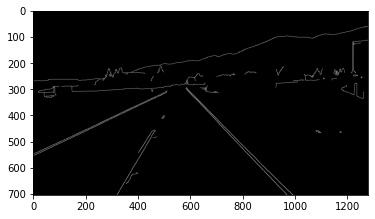

In [25]:
def canny_edge(image):
    gray_conversion= cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur_conversion = cv2.GaussianBlur(gray_conversion, (5,5),0)
    canny_conversion = cv2.Canny(blur_conversion, 50,150)
    return canny_conversion

canny_conversion=canny_edge(image)
plt.imshow(canny_conversion,cmap='gray')

### Region of Interest

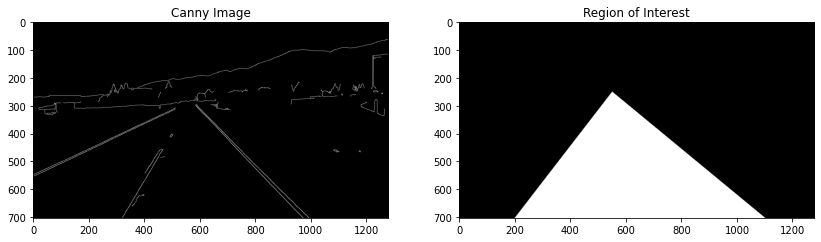

In [27]:
def reg_of_interest(image):
    Image_height = image.shape[0]
    polygons = np.array([[(200, Image_height), (1100, Image_height), (550, 250)]])
    image_mask = np.zeros_like(image)
    cv2.fillPoly(image_mask, polygons, 255)
    return image_mask

cropped_mask = reg_of_interest(canny_conversion)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1);plt.title('Canny Image');plt.imshow(canny_conversion,cmap='gray')
plt.subplot(1,2,2);plt.title('Region of Interest');plt.imshow(cropped_mask,cmap='gray')

### Applying bitwise_and

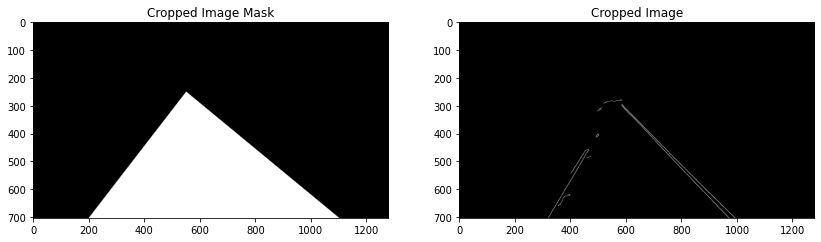

In [83]:
def crop_image(image,image_mask):
    masking_image = cv2.bitwise_and(image,image_mask)
    return masking_image

cropped_image = crop_image(canny_conversion,cropped_mask)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1);plt.title('Cropped Image Mask');plt.imshow(cropped_mask,cmap='gray')
plt.subplot(1,2,2);plt.title('Cropped Image');plt.imshow(cropped_image,cmap='gray')

## Plotting Line Markings

In [132]:
def show_lines(image, lines):
    lines_image = np.zeros_like(image)
    if lines is not None :
        for line in lines:
            X1, Y1, X2, Y2 = line.reshape(4)
            cv2.line(lines_image, (X1, Y1), (X2, Y2), (255,0,0), 10)
    return lines_image

In [66]:
lane_lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength= 40, maxLineGap=5)

In [67]:
line_image = show_lines(image, lane_lines)

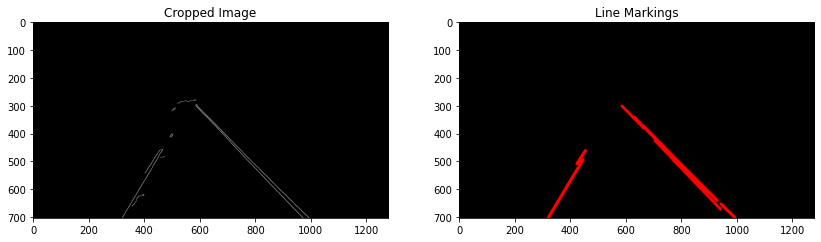

In [68]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1);plt.title('Cropped Image');plt.imshow(cropped_image,cmap='gray')
plt.subplot(1,2,2);plt.title('Line Markings');plt.imshow(linelines_image)

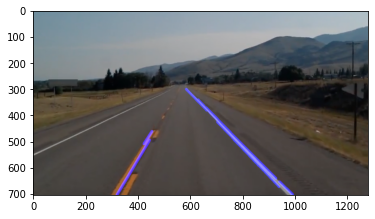

In [69]:
combine_image_prev = cv2.addWeighted(lanelines_image, 0.8, line_image, 1, 1)
plt.imshow(combine_image_prev[...,::-1])

### Detect road marking in images

In [135]:
def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1- intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return np.array([x1, y1, x2, y2])

In [115]:
def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        if x2==x1:
            continue
        slope = (y2-y1)/(x2-x1)
        intercept = y1 - slope*x1
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    left_fit_average =np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis =0)
    left_line =make_coordinates(image, left_fit_average)
    right_line = make_coordinates(image, right_fit_average)

    return np.array([left_line, right_line])

In [75]:
averaged_lines = average_slope_intercept(lanelines_image, lane_lines)

In [76]:
line_image = show_lines(lanelines_image, averaged_lines)

In [77]:
combine_image = cv2.addWeighted(lanelines_image, 0.8, line_image, 1, 1)

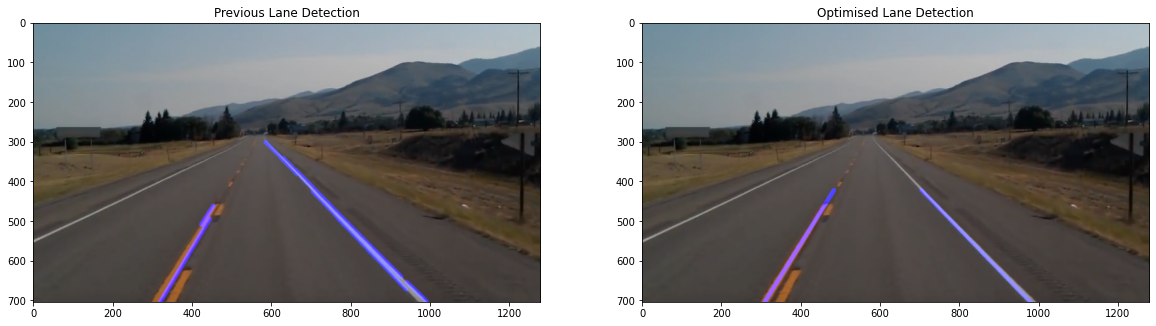

In [80]:
plt.figure(figsize=(20,10))
plt.subplot(121);plt.title('Previous Lane Detection');plt.imshow(combine_image_prev[...,::-1])
plt.subplot(122);plt.title('Optimised Lane Detection');plt.imshow(combine_image[...,::-1])

### Detecting road markings in video

In [136]:
cap = cv2.VideoCapture("test2.mp4")
import math
while(cap.isOpened()):
    try:
        _, frame = cap.read()
        canny_image = canny_edge(frame)
        cropped_mask = reg_of_interest(canny_image)
        cropped_image = crop_image(canny_image,cropped_mask)
        lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100,np.array([]), minLineLength=40,maxLineGap=5)
        averaged_lines = average_slope_intercept(frame, lines)
        line_image = show_lines(frame, averaged_lines)
        combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
        cv2.imshow("result", combo_image)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    except:
        continue
cap.release()
cv2.destroyAllWindows()

c:\users\sudar\.conda\envs\tf_gpu\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\sudar\.conda\envs\tf_gpu\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [137]:
cv2.destroyAllWindows()